In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import glob
import pysam

In [21]:
#gathered metadata with Roozbeh's help using:
#Hi Rob, yes you can use this metadata file for mapping cell barcodes to celltypes:
#/oak/stanford/groups/horence/Roozbeh/single_cell_project/utility_files/meta_data/Tabula_Sapiens/TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.csv
#It has metadata for all TS data. For example, to get the info for TSP2 10X you can do the following:
# grep "TSP2"  TSP1_TSP15_scvi_donor-method_normalized-log1p-scaled_annotated.csv | grep "10X"
#We use the combination of tissue, compartrment , and consensus_prediction as the ontology for each cell.

meta_df = pd.read_csv(
    '/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/tsp2_meta.csv',
)
meta_df.head().T

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4
cell_id,AAACCCAAGGCTTAGG_TSP2_Bladder_NA_10X_1_1,AAACCCAAGTTTGTCG_TSP2_Bladder_NA_10X_1_1,AAACCCACAACCCTAA_TSP2_Bladder_NA_10X_1_1,AAACCCAGTCATAAAG_TSP2_Bladder_NA_10X_1_1,AAACCCAGTCCTATAG_TSP2_Bladder_NA_10X_1_1
10X_run,NaN,NaN,NaN,NaN,NaN
pilot,NaN,NaN,NaN,NaN,NaN
tissue,Bladder,Bladder,Bladder,Bladder,Bladder
subtissue,NaN,NaN,NaN,NaN,NaN
method,10X,10X,10X,10X,10X
10X_sample,NaN,NaN,NaN,NaN,NaN
10X_replicate,NaN,NaN,NaN,NaN,NaN
notes,NaN,NaN,NaN,NaN,NaN
seqrun,2,2,2,2,2


In [33]:
meta_df['Annotation'].value_counts()

macrophage                               9667
classical monocyte                       9610
kidney epithelial cell                   8158
mesenchymal stem cell                    7130
memory b cell                            6578
                                         ... 
intestinal tuft cell                       14
adventitial cell                           12
serous cell of epithelium of bronchus       7
conventional dendritic cell                 3
plasmacytoid dendritic cell                 2
Name: Annotation, Length: 84, dtype: int64

In [39]:
cell_id_to_ann = dict(meta_df[['cell_id','Annotation']].values)

In [32]:
bam_paths = pd.read_csv('/oak/stanford/groups/horence/rob/isoform_localizations/SRRS/tsp2_paths.csv')
bam_paths

,path,tissue,sample_name
0,/scratch/groups/horence/Roozbeh/single_cell_pr...,Bladder,TSP2_Bladder_NA_10X_1_1
1,/scratch/groups/horence/Roozbeh/single_cell_pr...,Bladder,TSP2_Bladder_NA_10X_1_1
2,/scratch/groups/horence/Roozbeh/single_cell_pr...,Bladder,TSP2_Bladder_NA_10X_1_1
3,/scratch/groups/horence/Roozbeh/single_cell_pr...,Bladder,TSP2_Bladder_NA_10X_1_1
4,/scratch/groups/horence/Roozbeh/single_cell_pr...,Bladder,TSP2_Bladder_NA_10X_1_2
...,...,...,...
135,/scratch/groups/horence/Roozbeh/single_cell_pr...,Vasculature_Aorta,TSP2_Vasculature_Aorta_10X_1_1
136,/scratch/groups/horence/Roozbeh/single_cell_pr...,Vasculature_Aorta,TSP2_Vasculature_Aorta_10X_1_2
137,/scratch/groups/horence/Roozbeh/single_cell_pr...,Vasculature_Aorta,TSP2_Vasculature_Aorta_10X_1_2
138,/scratch/groups/horence/Roozbeh/single_cell_pr...,Vasculature_Aorta,TSP2_Vasculature_Aorta_10X_1_2


In [72]:
regions = {
    'Timp3_gene':('chr10',86300372,86349506),
    'Timp3_upstream':('chr10',86346902,86347515),
    'Timp3_dwstream':('chr10',86348990,86349699),
    'Flt1_gene':('chr5',147561604,147726011),
    'Flt1_long':('chr5',147560562,147564941),
    'Flt1_short':('chr5',147634121,147640192),
}

region_counts = {
    'region':[],
    'tissue':[],
    'ontology':[],
    'cell_id':[],
}

#Loop through bams
for i,r in bam_paths.iterrows():
    with pysam.AlignmentFile(r['path'],'rb') as bam:
        
        #Loop through regions
        for name,region in regions.items():
            
            #Loop through reads
            for read in bam.fetch(*region):
                _,bc,umi = read.query_name.split('_') #BC/UMI are appended to query_name
                cell_id = bc+'_'+r['sample_name']
                ann = cell_id_to_ann.get(cell_id)
                
                if not ann:
                    continue
                    
                region_counts['region'].append(name)
                region_counts['tissue'].append(r['tissue'])
                region_counts['ontology'].append(ann)
                region_counts['cell_id'].append(cell_id)


In [73]:
counts_df = pd.DataFrame(region_counts).groupby(['region','tissue','ontology']).agg(
    num_cells = ('cell_id','nunique'),
    read_counts = ('cell_id','count'),
).reset_index()
counts_df

,region,tissue,ontology,num_cells,read_counts
0,Flt1_gene,BM_vertebralbody,b cell,3,4
1,Flt1_gene,BM_vertebralbody,cd4-positive helper t cell,7,32
2,Flt1_gene,BM_vertebralbody,"cd8-positive, alpha-beta t cell",77,830
3,Flt1_gene,BM_vertebralbody,classical monocyte,7,31
4,Flt1_gene,BM_vertebralbody,dendritic cell,2,3
...,...,...,...,...,...
597,Timp3_upstream,Vasculature_Aorta,endothelial cell,12,16
598,Timp3_upstream,Vasculature_Aorta,fibroblast,40,49
599,Timp3_upstream,Vasculature_Aorta,macrophage,10,18
600,Timp3_upstream,Vasculature_Aorta,pericyte cell,5,5


In [78]:
#Ontologies where Flt1 is highly expressed
counts_df[
    counts_df['region'].eq('Flt1_gene') &
    counts_df['num_cells'].ge(50) &
    counts_df['read_counts'].ge(100)
]['ontology'].unique()

array(['cd8-positive, alpha-beta t cell', 'bladder urothelial cell',
       'macrophage', 't cell', 'classical monocyte', 'nk cell',
       'kidney epithelial cell', 'basal cell', 'lung ciliated cell',
       'type ii pneumocyte', 'cd4-positive, alpha-beta memory t cell',
       'cd8-positive, alpha-beta memory t cell', 'memory b cell',
       'naive thymus-derived cd4-positive, alpha-beta t cell',
       'mesenchymal stem cell', 'cd4-positive helper t cell',
       'fibroblast'], dtype=object)

In [79]:
#Ontologies where Timp3 is highly expressed
counts_df[
    counts_df['region'].eq('Timp3_gene') &
    counts_df['num_cells'].ge(50) &
    counts_df['read_counts'].ge(100)
]['ontology'].unique()

array(['type ii pneumocyte', 'mesenchymal stem cell',
       'skeletal muscle satellite stem cell',
       'cd4-positive helper t cell', 'fibroblast'], dtype=object)

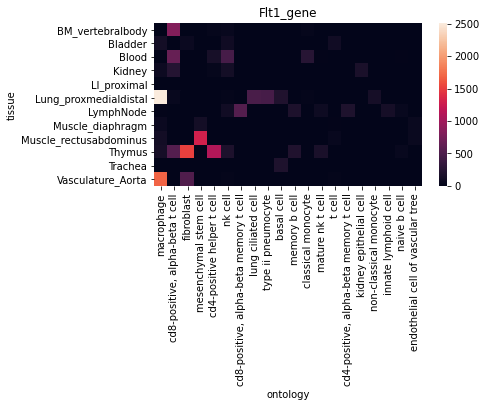

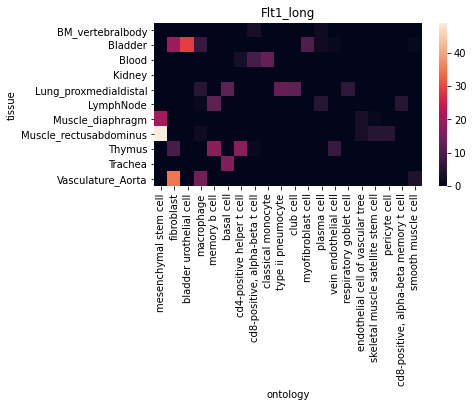

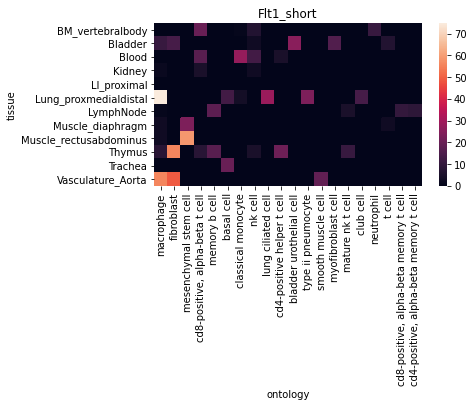

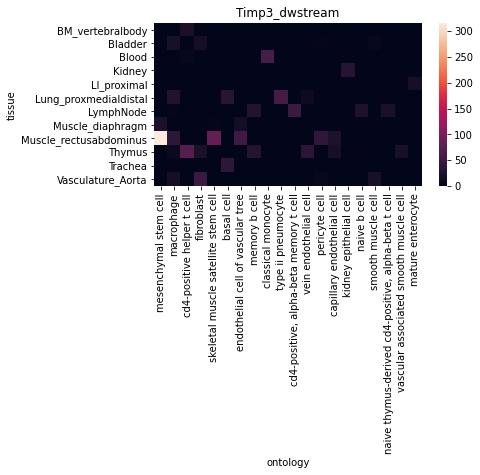

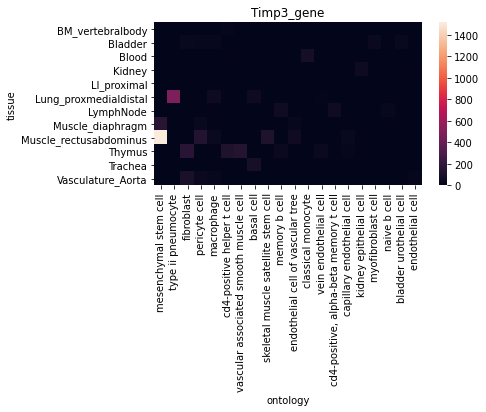

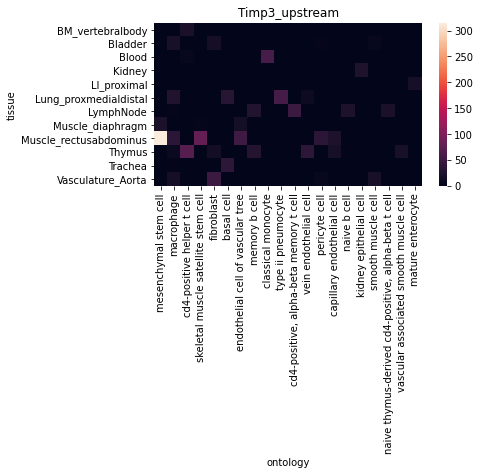

In [109]:
for name,g in counts_df.groupby('region'):
    fig = plt.figure(figsize=(6,3))
    ont_tissue_counts = g.pivot_table(
        index = 'tissue',
        columns = 'ontology',
        values = 'read_counts',
        aggfunc = 'sum',
    ).fillna(0)
    
    high_count_onts = ont_tissue_counts.sum().sort_values(ascending=False).index[:20]
    ont_tissue_counts = ont_tissue_counts[high_count_onts]
    
    sns.heatmap(ont_tissue_counts)
    plt.title(name)
    plt.show()
    plt.close()


In [68]:
meta_df.head().T

,0,1,2,3,4
cell_id,AAACCCAAGGCTTAGG_TSP2_Bladder_NA_10X_1_1,AAACCCAAGTTTGTCG_TSP2_Bladder_NA_10X_1_1,AAACCCACAACCCTAA_TSP2_Bladder_NA_10X_1_1,AAACCCAGTCATAAAG_TSP2_Bladder_NA_10X_1_1,AAACCCAGTCCTATAG_TSP2_Bladder_NA_10X_1_1
10X_run,NaN,NaN,NaN,NaN,NaN
pilot,NaN,NaN,NaN,NaN,NaN
tissue,Bladder,Bladder,Bladder,Bladder,Bladder
subtissue,NaN,NaN,NaN,NaN,NaN
method,10X,10X,10X,10X,10X
10X_sample,NaN,NaN,NaN,NaN,NaN
10X_replicate,NaN,NaN,NaN,NaN,NaN
notes,NaN,NaN,NaN,NaN,NaN
seqrun,2,2,2,2,2


In [69]:
meta_df['Annotation'].eq(meta_df['free_annotation']).all()

False

In [70]:
meta_df['Annotation'].unique()

array(['macrophage', 'bladder urothelial cell', 'fibroblast',
       'plasma cell', 't cell', 'myofibroblast cell', 'b cell', 'nk cell',
       'vein endothelial cell', 'mast cell', 'pericyte cell',
       'smooth muscle cell', 'capillary endothelial cell',
       'endothelial cell of lymphatic vessel', 'classical monocyte',
       'erythrocyte', 'naive b cell', 'cd4-positive helper t cell', nan,
       'memory b cell', 'intermediate monocyte',
       'cd8-positive, alpha-beta t cell', 'platelet', 'mature nk t cell',
       'neutrophil', 'conventional dendritic cell',
       'non-classical monocyte', 'erythroid progenitor', 'dendritic cell',
       'hematopoietic stem cell', 'kidney epithelial cell',
       'endothelial cell', 'immature enterocyte',
       'intestinal crypt stem cell',
       'transit amplifying cell of large intestine', 'mature enterocyte',
       'gut endothelial cell', 'intestinal enteroendocrine cell',
       'paneth cell of epithelium of large intestine', 'goblet 

In [71]:
meta_df['free_annotation'].unique()

array(['macrophage', 'bladder urothelial cell', 'fibroblast',
       'plasma cell', 't cell', 'myofibroblast cell', 'b cell', 'nk cell',
       'vein endothelial cell', 'mast cell', 'pericyte cell',
       'smooth muscle cell', 'capillary endothelial cell',
       'endothelial cell of lymphatic vessel', 'monocyte',
       'platelet doublet', 'naive b cell', 'CD4 t cell', 'doublet nk',
       'memory b cell', 'CD8 t cell', 'erythrocyte doublet',
       'cd8-positive, alpha-beta t cell', 'erythrocyte', 'NK cell',
       'hematopoietic stem cell', 'NAMPT neutrophil',
       'myeloid progenitor', 'plasmablast', 'granulocyte',
       'CD24 Neutrophil', 'cd4-positive helper t cell',
       'erythroid progenitor', 'dendritic cell', 'kidney epithelial cell',
       'endothelial cell', 'immature enterocyte',
       'intestinal crypt stem cell',
       'transit amplifying cell of large intestine', 'mature enterocyte',
       'gut endothelial cell', 'intestinal enteroendocrine cell',
       'pane